In [29]:
import healsparse as hs
import healpy as hp
import fitsio as fio
import numpy as np
import glob
import pickle
from tqdm import tqdm
from des_y6utils import mdet
import matplotlib
import skyproj
import proplot as pplt
import matplotlib.pyplot as plt
import os
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [2]:
mdet_files = glob.glob('/global/cfs/cdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V5b/jackknife_patches_blinded/patch-*.fits')
with open('/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v5b/inverse_variance_weight_v5b_s2n_10-1000_Tratio_0.5-5.pickle', 'rb') as handle:
    wgt_dict = pickle.load(handle)

# FOR 'WMOM' MEASUREMENT, USE
snmin = 10
snmax = 1000
sizemin = 0.5
sizemax = 5.0
steps = 20

In [3]:
def _accum_shear_per_tile(res, res_num, d_pix, mdet_step, g, weight):

    for step in ['noshear', '1p', '1m', '2p', '2m']:
        msk = (mdet_step == step)
        p = d_pix[msk]

        np.add.at(
            res[step], 
            (p), 
            g[msk]*weight[msk],
        )
        np.add.at(
            res_num["num_" + step], 
            (p), 
            1*weight[msk],
        )
    # return res, res_num
    
def _accum_shape_noise(res, d_pix, g1, g2, weight, mean_e1map, mean_e2map, response_map):

        
    p = d_pix

    np.add.at(
        res['e1'], 
        (p), 
        weight**2 * (g1 - mean_e1map)**2,
    )
    
    np.add.at(
        res['e2'], 
        (p), 
        weight**2 * (g2 - mean_e2map)**2,
    )
    
    np.add.at(
        res['w2'], 
        (p), 
        weight**2,
    )
    
    np.add.at(
        res['w'], 
        (p), 
        weight,
    )
    
    np.add.at(
        res['ws'], 
        (p), 
        weight*response_map,
    )

    # return res, res_num

def assign_loggrid(x, y, xmin, xmax, xsteps, ymin, ymax, ysteps):
    from math import log10
    # return x and y indices of data (x,y) on a log-spaced grid that runs from [xy]min to [xy]max in [xy]steps

    logstepx = log10(xmax/xmin)/xsteps
    logstepy = log10(ymax/ymin)/ysteps

    indexx = (np.log10(x/xmin)/logstepx).astype(int)
    indexy = (np.log10(y/ymin)/logstepy).astype(int)

    indexx = np.maximum(indexx,0)
    indexx = np.minimum(indexx, xsteps-1)
    indexy = np.maximum(indexy,0)
    indexy = np.minimum(indexy, ysteps-1)

    return indexx,indexy

def _find_shear_weight(d, wgt_dict, snmin, snmax, sizemin, sizemax, steps, mdet_mom):
    
    if wgt_dict is None:
        weights = np.ones(len(d))
        return weights

    shear_wgt = wgt_dict['weight']
    smoothing = True
    if smoothing:
        from scipy.ndimage import gaussian_filter
        smooth_response = gaussian_filter(wgt_dict['response'], sigma=2.0)
        shear_wgt = (smooth_response/wgt_dict['meanes'])**2

    indexx, indexy = assign_loggrid(d[mdet_mom+'_s2n'], d[mdet_mom+'_T_ratio'], snmin, snmax, steps, sizemin, sizemax, steps)
    weights = np.array([shear_wgt[x, y] for x, y in zip(indexx, indexy)])
    # response = np.array([shear_response[x, y] for x, y in zip(indexx, indexy)])
    
    return weights

In [17]:
nside = 64
# d_flat = fio.read('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/v2/metadetection_v2_s2n_sizer_weight.fits')
npix = hp.nside2npix(nside)
# pix = hp.ang2pix(nside, d_flat['ra'], d_flat['dec'], lonlat=True, nest=True)
# unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)

In [25]:
res_e1 = np.zeros(npix, dtype=[('noshear', 'f8'), ('1p', 'f8'), ('1m', 'f8'), ('2p', 'f8'), ('2m', 'f8')])
res_num_e1 = np.zeros(npix, dtype=[('num_noshear', 'f8'), ('num_1p', 'f8'), ('num_1m', 'f8'), ('num_2p', 'f8'), ('num_2m', 'f8')])
res_e2 = np.zeros(npix, dtype=[('noshear', 'f8'), ('1p', 'f8'), ('1m', 'f8'), ('2p', 'f8'), ('2m', 'f8')])
res_num_e2 = np.zeros(npix, dtype=[('num_noshear', 'f8'), ('num_1p', 'f8'), ('num_1m', 'f8'), ('num_2p', 'f8'), ('num_2m', 'f8')])

for fname in tqdm(mdet_files):

    d = fio.read(fname)
    msk = mdet.make_mdet_cuts(d, 5)
    mdet_mom='gauss'
    d = d[msk]
    
    # Color-split: blue-[-2.00, 0.76], mid-[0.76, 1.49], red-[1.49, 4.00]
    mag_g = mdet._compute_asinh_mags(d["pgauss_band_flux_g"], 0)
    mag_i = mdet._compute_asinh_mags(d["pgauss_band_flux_i"], 2)
    gmi = mag_g - mag_i
    msk_color = ((gmi > 1.49) & (gmi < 4.00))
    d = d[msk_color]
    
    hpix = hp.ang2pix(nside, d['ra'], d['dec'], lonlat=True, nest=True)
    
    shear_wgt = _find_shear_weight(d, wgt_dict, snmin, snmax, sizemin, sizemax, steps, mdet_mom) # shear_wgt = np.ones(len(d))
    # shear_wgt = 1/(0.17**2 + 0.5*(d[mdet_mom+'_g_cov_1_1'] + d[mdet_mom+'_g_cov_2_2']))
    # res_hpix = _accum_shear_per_tile(res_hpix, hpix, d['mdet_step'], d[mdet_mom+'_g_1'], d[mdet_mom+'_g_2'], shear_wgt)
    _accum_shear_per_tile(res_e1, res_num_e1, hpix, d['mdet_step'], d[mdet_mom+'_g_1'], shear_wgt)
    _accum_shear_per_tile(res_e2, res_num_e2, hpix, d['mdet_step'], d[mdet_mom+'_g_2'], shear_wgt)

100%|██████████| 200/200 [50:11<00:00, 15.06s/it]


In [26]:
# compute response in each healpix bin.
desy6_map = np.zeros(hp.nside2npix(nside))
desy6_e1map = np.zeros(hp.nside2npix(nside))
desy6_e2map = np.zeros(hp.nside2npix(nside))
cnt = 0
for p in tqdm(range(npix)):
    if res_e1[p]['1p'] == 0:
        cnt += 1
        continue
    g1p = res_e1[p]['1p'] / res_num_e1[p]['num_1p']
    g1m = res_e1[p]['1m'] / res_num_e1[p]['num_1m']
    R11 = (g1p - g1m) / 2 / 0.01

    g2p = res_e2[p]['2p'] / res_num_e2[p]['num_2p']
    g2m = res_e2[p]['2m'] / res_num_e2[p]['num_2m']
    R22 = (g2p - g2m) / 2 / 0.01

    R = (R11+R22)/2
    desy6_map[p] = R
    desy6_e1map[p] = res_e1[p]['noshear']/res_num_e1[p]['num_noshear']
    desy6_e2map[p] = res_e2[p]['noshear']/res_num_e2[p]['num_noshear']
print(cnt)

  0%|          | 0/49152 [00:00<?, ?it/s]<ipython-input-26-c1a4081046d7>:11: RuntimeWarning: invalid value encountered in double_scalars
  g1m = res_e1[p]['1m'] / res_num_e1[p]['num_1m']
<ipython-input-26-c1a4081046d7>:14: RuntimeWarning: invalid value encountered in double_scalars
  g2p = res_e2[p]['2p'] / res_num_e2[p]['num_2p']
<ipython-input-26-c1a4081046d7>:20: RuntimeWarning: invalid value encountered in double_scalars
  desy6_e1map[p] = res_e1[p]['noshear']/res_num_e1[p]['num_noshear']
<ipython-input-26-c1a4081046d7>:21: RuntimeWarning: invalid value encountered in double_scalars
  desy6_e2map[p] = res_e2[p]['noshear']/res_num_e2[p]['num_noshear']
100%|██████████| 49152/49152 [00:00<00:00, 602150.98it/s]

42793


Text(0.5, 1.08, 'weighted shear response (blue)')

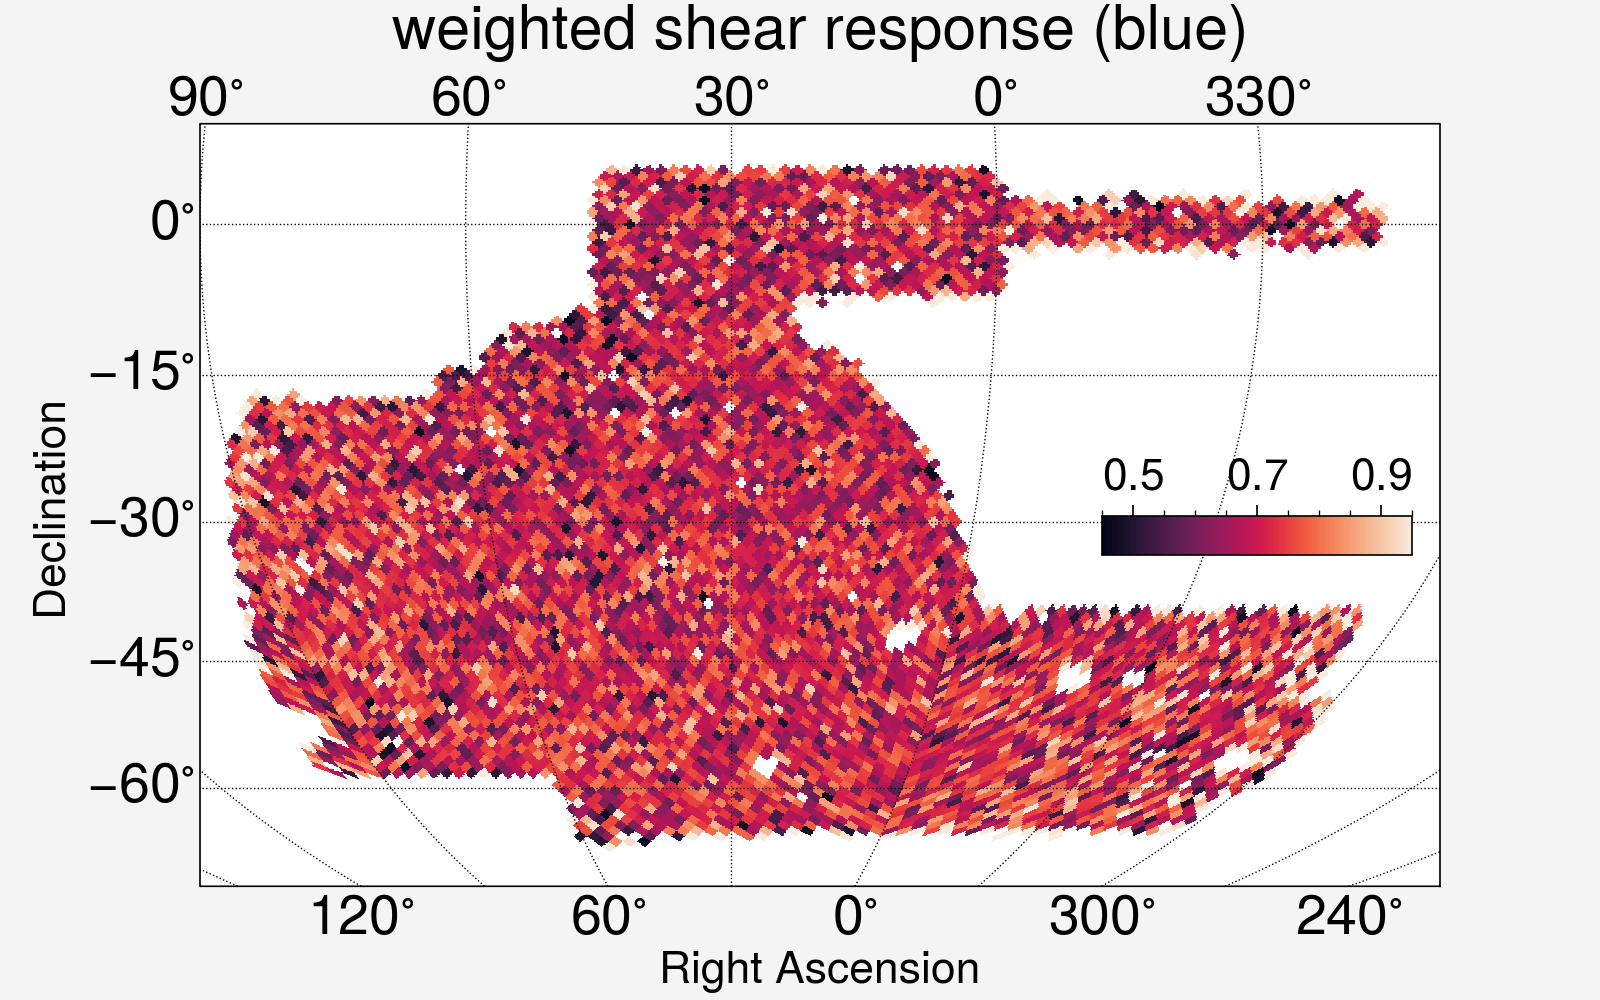

In [30]:
# res = desy6_map #/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60))
# hsp_map = hs.HealSparseMap(nside_coverage=nside, healpix_map=res)
# if not os.path.exists('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shear_response_map_nside'+str(nside)+'_red.fits'):
#     hsp_map.write('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shear_response_map_nside'+str(nside)+'_red.fits')
hsp_map = hs.HealSparseMap.read('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shear_response_map_nside64_blue.fits')

fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('rocket')
# norm = matplotlib.colors.Normalize(vmin=0.6, vmax=0.9)
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none')
_ = m.draw_hspmap(hsp_map, cmap=my_cmap, vmin=0.5, vmax=0.9, zoom=False)
m.draw_inset_colorbar(fontsize=16)
plt.title('weighted shear response (blue)', y=1.08)
# plt.savefig('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/spatial_dist_shear_response_64_red.pdf', bbox_inches='tight', dpi=100)

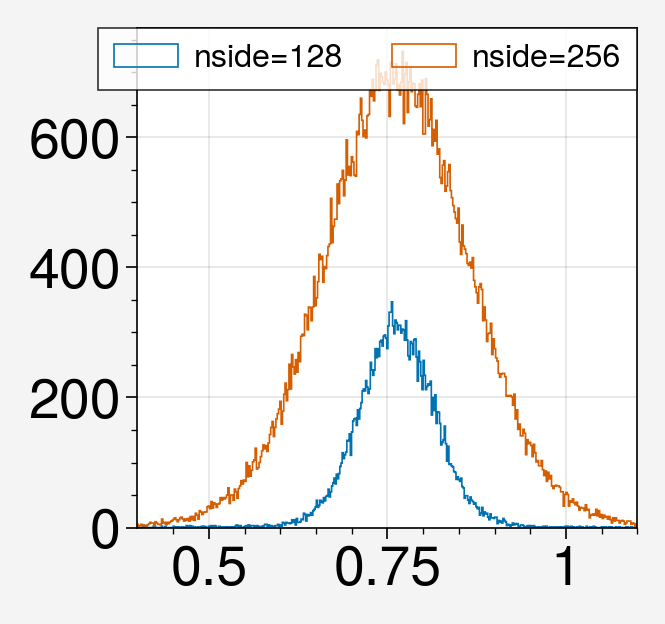

In [18]:
hm = hs.HealSparseMap.read('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_v5/shear_response_map_nside128.fits')
hm2 = hs.HealSparseMap.read('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_v5/shear_response_map_nside256.fits')
sig = hm.get_values_pix(hm.valid_pixels)
sig2 = hm2.get_values_pix(hm2.valid_pixels)

matplotlib.rcParams.update({'legend.fontsize': 'xx-small'})
fig,ax=pplt.subplots()
sig_ = sig[sig != 0]
sig2_ = sig2[sig2 != 0]
ax.hist(sig_, bins=10000, histtype='step', label='nside=128')
ax.hist(sig2_, bins=10000, histtype='step', label='nside=256')
ax.set_xlim(0.4, 1.1)
ax.legend()

## shape noise

In [16]:
res_e = np.zeros(npix, dtype=[('e1', 'f8'), ('e2', 'f8'), ('w', 'f8'), ('w2', 'f8'), ('ws', 'f8')])
for fname in tqdm(mdet_files):

    d = fio.read(fname)
    msk = mdet.make_mdet_cuts(d, 5)
    mdet_mom='gauss'
    d = d[msk & (d['mdet_step'] == 'noshear')]
    
    hpix = hp.ang2pix(nside, d['ra'], d['dec'], lonlat=True, nest=True)
    
    shear_wgt = _find_shear_weight(d, wgt_dict, snmin, snmax, sizemin, sizemax, steps, mdet_mom) # shear_wgt = np.ones(len(d))
    # shear_wgt = 1/(0.17**2 + 0.5*(d[mdet_mom+'_g_cov_1_1'] + d[mdet_mom+'_g_cov_2_2']))
    _accum_shape_noise(res_e, hpix, d[mdet_mom+'_g_1'], d[mdet_mom+'_g_2'], shear_wgt, desy6_e1map[hpix], desy6_e2map[hpix], desy6_map[hpix])

100%|██████████| 200/200 [39:43<00:00, 11.92s/it]


In [17]:
desy6_shape_noise_map = np.zeros(npix)
for p in tqdm(range(npix)):
    if res_e[p]['e1'] == 0:
        cnt += 1
        continue
    
    sigmae2 = 0.5 * (res_e[p]['e1']/res_e[p]['ws']**2 + res_e[p]['e2']/res_e[p]['ws']**2) * (res_e[p]['w']**2/res_e[p]['w2'])
    desy6_shape_noise_map[p] = np.sqrt(sigmae2)

 83%|████████▎ | 163500/196608 [00:00<00:00, 686854.31it/s]<ipython-input-17-3f2d32fd67ed>:7: RuntimeWarning: divide by zero encountered in double_scalars
  sigmae2 = 0.5 * (res_e[p]['e1']/res_e[p]['ws']**2 + res_e[p]['e2']/res_e[p]['ws']**2) * (res_e[p]['w']**2/res_e[p]['w2'])
100%|██████████| 196608/196608 [00:00<00:00, 711851.52it/s]


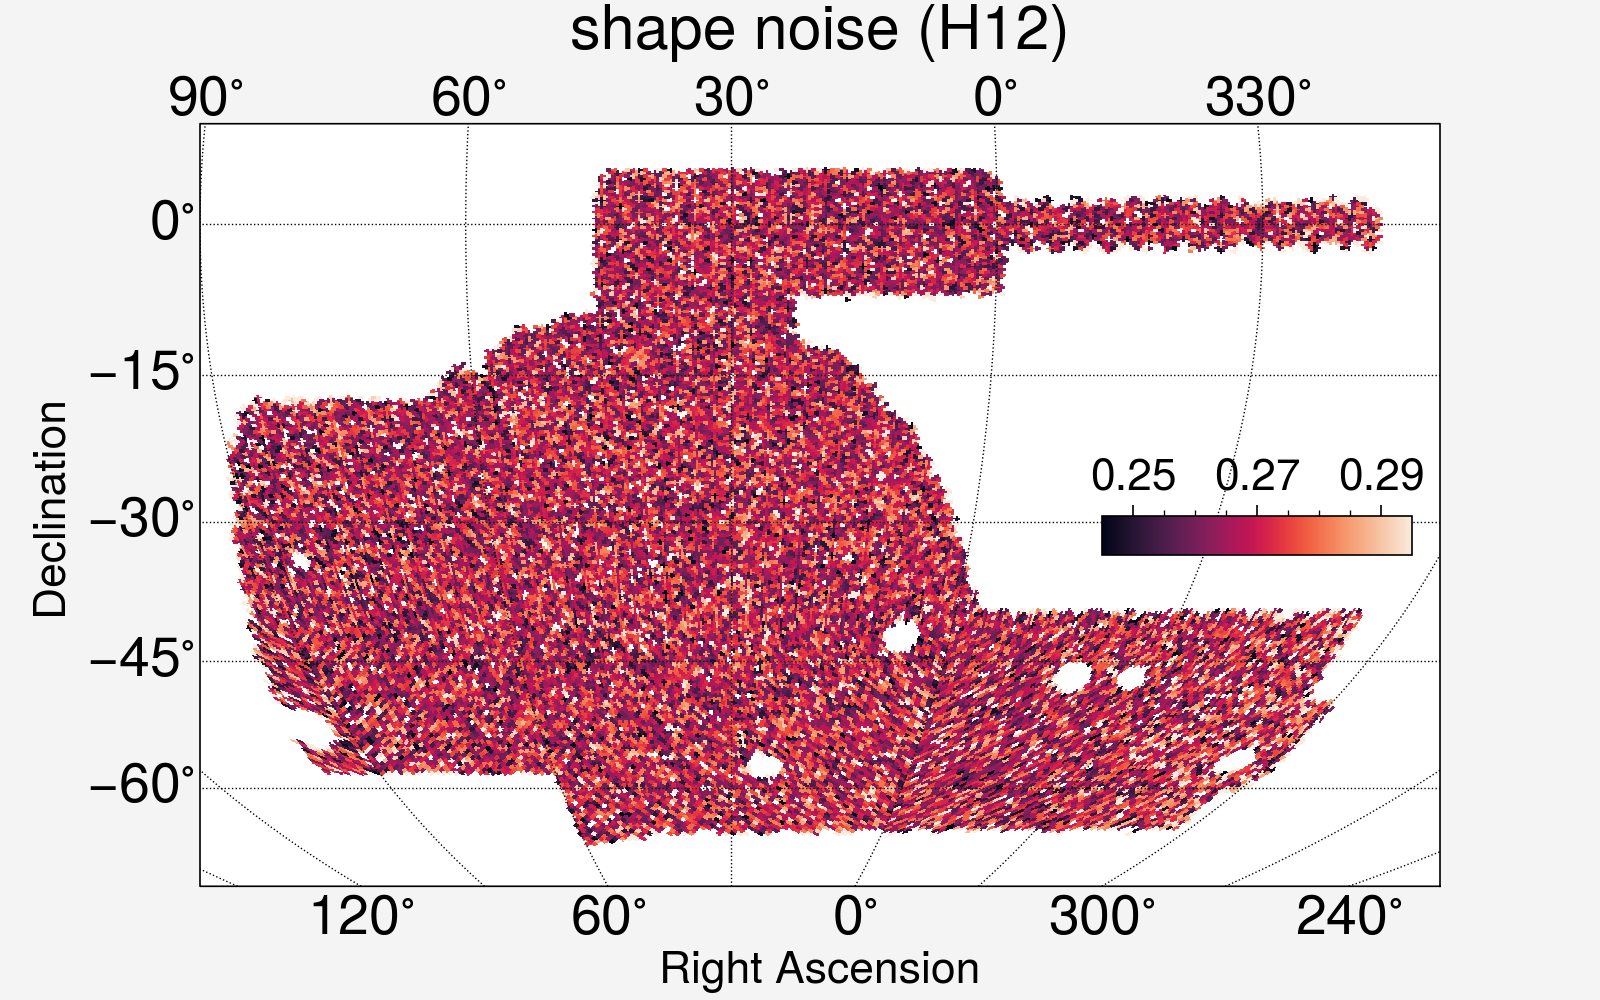

In [21]:
# res = desy6_shape_noise_map #/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60))
# hsp_map = hs.HealSparseMap(nside_coverage=nside, healpix_map=res)
# if not os.path.exists('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shape_noise_map_nside'+str(nside)+'.fits'):
#     hsp_map.write('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shape_noise_map_nside'+str(nside)+'.fits')
hsp_map = hs.HealSparseMap.read('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/shape_noise_map_nside128.fits')

fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('rocket')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none')
_ = m.draw_hspmap(hsp_map, cmap=my_cmap, vmin=0.24, vmax=0.30, zoom=False)
m.draw_inset_colorbar(format='%.2f', fontsize=16)
plt.title('shape noise (H12)', y=1.08)
plt.savefig('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/spatial_dist_shape_noise_128.pdf', bbox_inches='tight', dpi=100)

(0.1, 0.5)

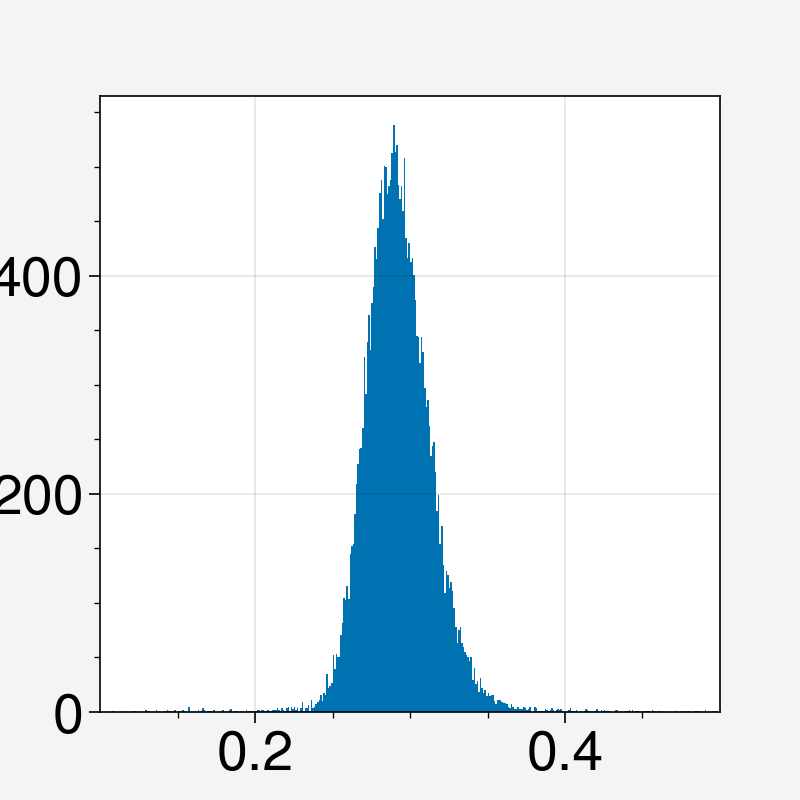

In [67]:
fig,ax=plt.subplots()
res_ = res[res != 0]
ax.hist(res_, bins=1000, range=[0,1.0])
ax.set_xlim(0.1, 0.5)

(<matplotlib.colorbar.Colorbar at 0x7f78037d3880>, <AxesHostAxes:>)

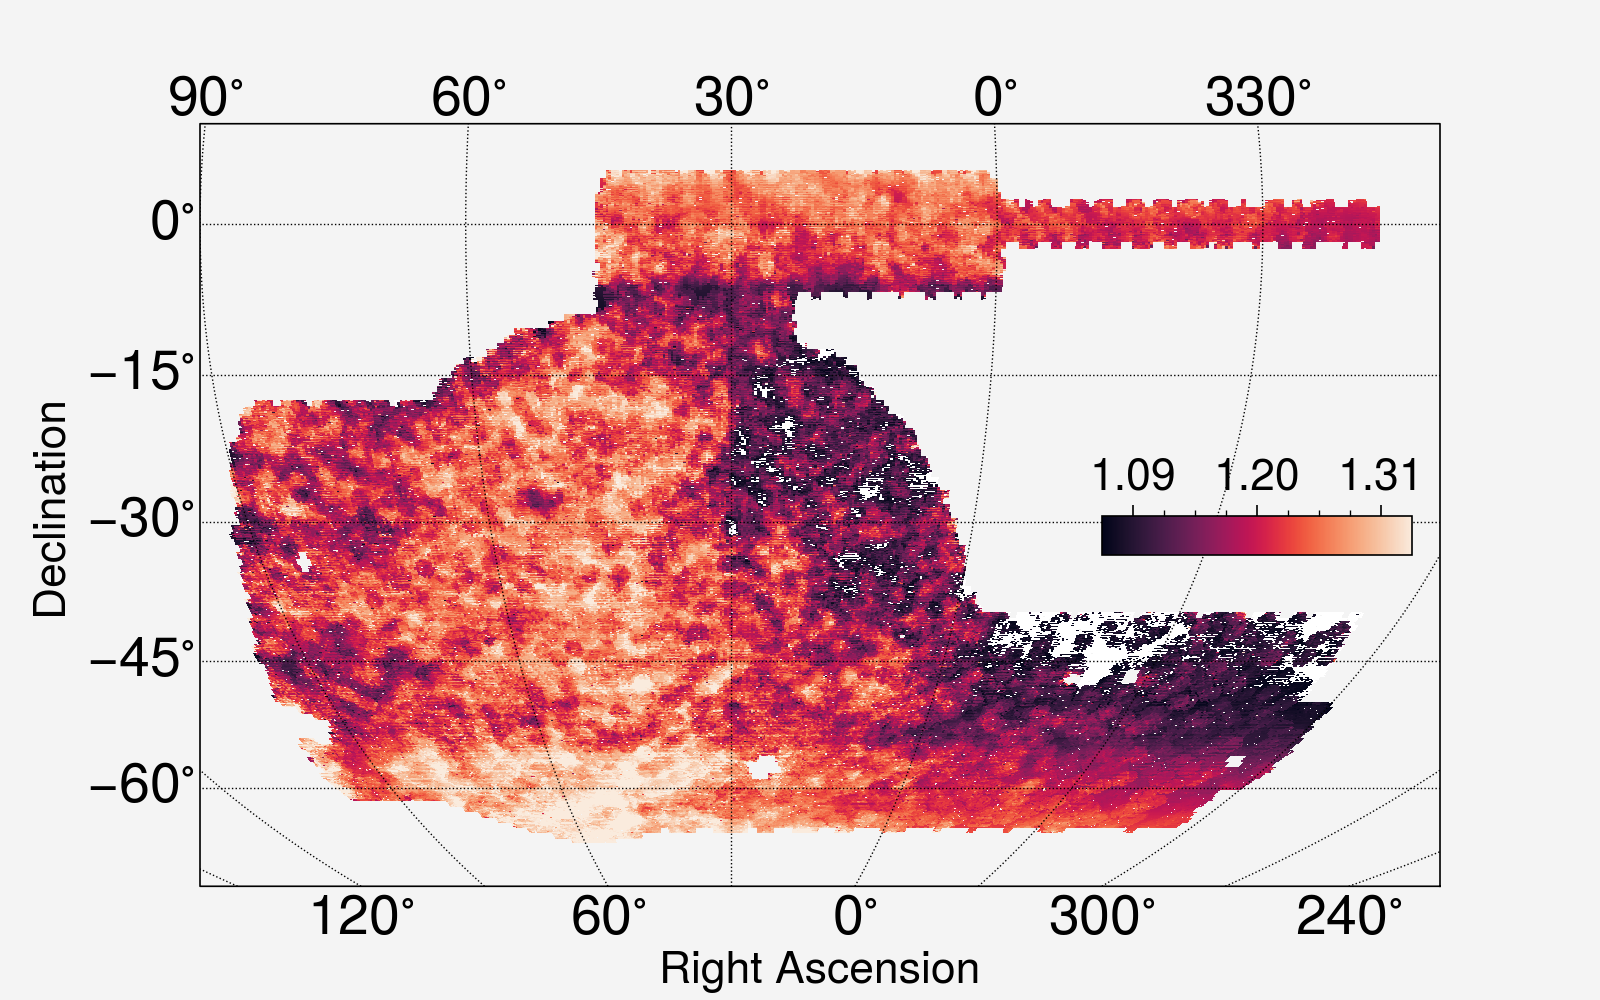

In [4]:
hsp_map = hs.HealSparseMap.read('/global/cfs/cdirs/des/myamamot/survey_property_maps/y6a2_decasu_r_airmass_wmean.hs')
fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('rocket')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none')
_ = m.draw_hspmap(hsp_map, cmap=my_cmap, zoom=False)
m.draw_inset_colorbar(format='%.2f', fontsize=16)